In [1]:
from fastai import *
from fastai.tabular import *
from fastai.tabular.data import *

In [2]:
import pandas as pd
from collections import Counter

In [3]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/NSLKDD/NSLKDD_Full.csv'
dataset = pd.read_csv(path)

### ***PRE-ELABORAZIONE DEI DATI***

In [4]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [5]:
dataset.head()

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,binlabel,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,normal,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,anomaly,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,normal,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,normal,normal


In [6]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder delle due variabili target, quindi da stringhe a interi sia in test che in train e salvo i valori nelle variabili y_test a y_train
# y_test viene utilizzata per la valutazione del modello

y_train_bin = LabelEncoder().fit_transform(train['binlabel'])
y_train = LabelEncoder().fit_transform(train['label'])
y_test_bin = LabelEncoder().fit_transform(test['binlabel'])
y_test = LabelEncoder().fit_transform(test['label'])

# tolgo la colonna 'binlabel' perché è una sotto variabile target
train = train.drop(['binlabel'], axis=1)
test = test.drop(['binlabel'], axis=1)

# sostituisco i valori originari con la codifica precedentemente fatta
target_index = train.columns.get_loc('label')
train.iloc[:, target_index] = y_train

# elimino la colonna relativa al target nel dataset di test poiché non utile
test = test.drop('label', axis=1)

In [7]:
train

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
136844,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,236,3,0.00,0.00,1.00,1.00,0.01,0.07,0.0,255,3,0.01,0.08,0.00,0.00,0.00,0.00,1.00,1.00,21,0
145105,0,tcp,http,SF,286,659,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,24,24,0.00,0.00,0.00,0.00,1.00,0.00,0.0,184,255,1.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00,21,2
20527,0,tcp,link,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,284,13,1.00,1.00,0.00,0.00,0.05,0.06,0.0,255,13,0.05,0.07,0.00,0.00,1.00,1.00,0.00,0.00,20,0
60596,0,udp,domain_u,SF,78,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,136,0.00,0.00,0.00,0.00,1.00,0.00,0.0,255,166,0.65,0.01,0.29,0.00,0.00,0.00,0.00,0.00,18,2
30861,0,icmp,eco_i,SF,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0.00,0.00,0.00,0.00,1.00,0.00,1.0,1,15,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90771,0,tcp,mtp,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,248,19,0.00,0.00,1.00,1.00,0.08,0.06,0.0,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,19,0
127947,804,tcp,http,RSTR,78404,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,77,77,0.03,0.03,0.97,0.97,1.00,0.00,0.0,255,253,0.99,0.01,0.00,0.00,0.01,0.01,0.42,0.43,15,0
42486,1,tcp,smtp,SF,1268,335,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0.00,0.00,0.00,0.00,1.00,0.00,1.0,255,150,0.59,0.02,0.00,0.00,0.00,0.00,0.00,0.00,21,2
32425,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,163,1,1.00,1.00,0.00,0.00,0.01,0.06,0.0,255,2,0.01,0.08,0.00,0.00,1.00,1.00,0.00,0.00,21,0


In [8]:
test

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
18338,0,icmp,eco_i,SF,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,42,0.0,0.0,0.0,0.0,1.00,0.00,1.00,2,6,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,15
110644,0,tcp,smtp,SF,1035,330,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,228,99,0.43,0.03,0.00,0.00,0.00,0.0,0.00,0.0,21
28887,0,tcp,http,SF,298,626,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,14,15,0.0,0.0,0.0,0.0,1.00,0.00,0.13,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,21
143071,0,tcp,sunrpc,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,0.0,0.0,1.0,1.0,0.25,1.00,1.00,214,10,0.02,0.03,0.00,0.20,0.00,0.0,0.13,1.0,14
103624,0,tcp,iso_tsap,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,247,10,1.0,1.0,0.0,0.0,0.04,0.06,0.00,255,10,0.04,0.07,0.00,0.00,1.00,1.0,0.00,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133441,0,icmp,eco_i,SF,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1,92,1.00,0.00,1.00,1.00,0.00,0.0,0.00,0.0,16
8998,0,tcp,finger,SF,8,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,1,0.00,0.02,0.00,0.00,0.62,0.0,0.00,0.0,18
63186,0,tcp,http,SF,219,2281,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,19,19,0.0,0.0,0.0,0.0,1.00,0.00,0.00,46,255,1.00,0.00,0.02,0.05,0.00,0.0,0.00,0.0,21
6875,0,tcp,http,SF,519,9166,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,17,0.0,0.0,0.0,0.0,1.00,0.00,0.12,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,21


In [9]:
print('Train: ', Counter(train['num_access_files']))
print("Test: ", Counter(test['num_access_files']))

Train:  Counter({0: 74258})
Test:  Counter({0: 74258})


In [10]:
test = test.drop('num_access_files', axis=1)
train = train.drop('num_access_files', axis=1)

### ***MODEL***

In [11]:
""" Definisco delle variabili utili al nostro modello per saper come trattare i dati. 
  Distinguendo variabile target, continue e categoriali. 
  Inoltre in procs vengono passati degli ottimizzatori che vengono applicati ai dati prima del training: in particolare con FillMissing vengono sostituiti
  eventuali valori NaN, Categorify si occupa di codificare le variabili categoriali e Normalize si occupa di normalizzare i valori continui."""

dep_var = 'label'
cat_names = ["protocol_type", "service", "flag"]
cont_names = [col for col in train.columns if col not in cat_names and col != dep_var]
procs = [FillMissing, Categorify, Normalize]

In [12]:
# Splitto il dataset in valid = 3.3666%
from sklearn.model_selection import train_test_split

def SplitSet(df):
     #train, test = train_test_split(df, test_size=0.1)
     train, valid = train_test_split(df, test_size=0.033666)
     split_val = len(train)
     train = train.append(valid)
     #return train, test, split_val
     return train, split_val

traindf, idx = SplitSet(train)

In [ ]:
idx

71758

In [ ]:
# Lista da passare al nostro tabular learner per effettuare la fase di test
test = TabularList.from_df(test, cat_names= cat_names, cont_names=cont_names, procs=procs)

# Lista contenete gli insiemi di training e validation, necessari per l'addrestamento del modello
data = TabularList.from_df(traindf, cat_names= cat_names, cont_names=cont_names, procs=procs)
data = data.split_by_idx(list(range(idx, len(traindf))))
data = data.label_from_df(cols=dep_var)
data = data.add_test(test, label= 0)
data = data.databunch()

In [26]:
# Creazione del nostro modello con due Hidden layers da, rispettivamente, 200 e 100 neuroni.
# Per valutare la performance durante l'addestramento viene usata l'accuratezza
learn = tabular_learner(data, layers=[200,100], metrics=accuracy, emb_drop=0.01, callback_fns=ShowGraph)

In [27]:
""" Visualizziamo la struttura del modello """
learn

Learner(data=TabularDataBunch;

Train: LabelList (71758 items)
x: TabularList
protocol_type tcp; service http; flag SF; duration -0.1117; symbolic -0.0065; src_bytes -0.0047; dst_bytes -0.0140; DoS -0.0861; wrong_fragment -0.0087; urgent -0.0949; hot -0.0580; num_failed_logins 1.2155; logged_in -0.0106; num_compromised -0.0385; root_shell -0.0232; su_attempted -0.0111; num_root -0.0236; num_file_creations -0.0181; num_shells -0.0407; num_outbound_cmds -0.0053; is_host_login -0.1118; is_guest_login -0.6883; count -0.3347; srv_count -0.5959; serror_rate -0.5916; srv_serror_rate -0.4056; rerror_rate -0.4036; srv_rerror_rate 0.7490; same_srv_rate -0.3471; diff_srv_rate -0.3741; srv_diff_host_rate 0.4580; dst_host_count 0.9864; dst_host_srv_count 1.0401; dst_host_same_srv_rate -0.4325; dst_host_diff_srv_rate -0.4722; dst_host_same_src_port_rate -0.2802; dst_host_srv_diff_host_rate -0.5986; dst_host_serror_rate -0.5858; dst_host_srv_serror_rate -0.4223; dst_host_rerror_rate -0.4052; dst_host

### ***TRAINING***

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


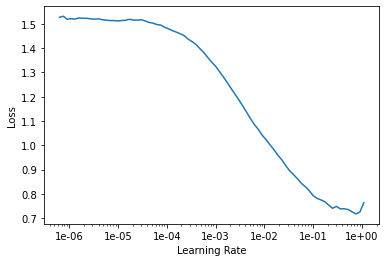

In [28]:
"""Troviamo il valore di learning rate da utilizzare per l'algoritmo di discesa del gradiente. 
  Prendiamo un valore mediano rispetto al punto di max pendenza """
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.051128,0.078206,0.984800,00:10
1,0.046787,0.212332,0.986800,00:10
2,0.034775,0.055685,0.986800,00:10
3,0.026065,0.023717,0.992400,00:10
4,0.031132,0.077907,0.990000,00:10
5,0.018078,0.033233,0.994400,00:10
6,0.014990,0.100238,0.990800,00:09
7,0.016854,0.019832,0.995200,00:10
8,0.012285,0.014202,0.994800,00:10
9,0.006649,0.017055,0.996400,00:10


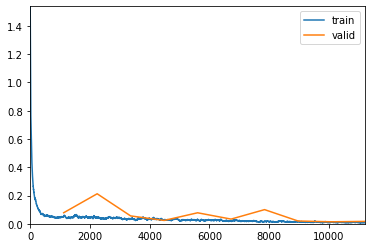

In [29]:
# Addestramento del modello
learn.fit_one_cycle(10, 1e-02, wd=0.02)

In [46]:
# Salvo il modello
save_path = './NLSKDD_FastAI'
learn.save(save_path)

In [ ]:
learn.load()

### ***PREDICTION***

In [30]:
# Valutazione del dataset di test ottenuto splittando il dataset di train
import numpy as np

pred, *_ = learn.get_preds(DatasetType.Test)
label = np.argmax(pred, 1)

y_pred = np.array(label)

In [31]:
y_pred

array([1, 2, 2, 1, ..., 2, 2, 2, 2])

### ***EVALUATION***

In [32]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({2: 38482, 0: 26498, 1: 7116, 3: 2100, 4: 62})
Pred: Counter({2: 38429, 0: 26480, 1: 7160, 3: 2142, 4: 47})


In [33]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

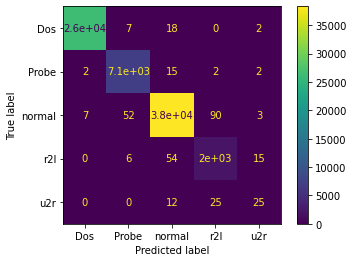

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

target_dict = {'Dos' : 0,
               'Probe' : 1,
               'normal' : 2,
               'r2l' : 3,
               'u2r' : 4}

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [35]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[47751     9]
  [   27 26471]]

 [[67077    65]
  [   21  7095]]

 [[35677    99]
  [  152 38330]]

 [[72041   117]
  [   75  2025]]

 [[74174    22]
  [   37    25]]]


In [47]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [26471  7095 38330  2025    25]
True negative:  [47751 67077 35677 72041 74174]
False positive:  [  9  65  99 117  22]
False negative:  [ 27  21 152  75  37]
True positive rate:  [0.998981 0.997049 0.99605  0.964286 0.403226]
True negative rate:  [0.999812 0.999032 0.997233 0.998379 0.999703]
False positive rate:  [0.000188 0.000968 0.002767 0.001621 0.000297]
False negative rate:  [0.001019 0.002951 0.00395  0.035714 0.596774]


In [36]:
print(cm)

[[26471     7    18     0     2]
 [    2  7095    15     2     2]
 [    7    52 38330    90     3]
 [    0     6    54  2025    15]
 [    0     0    12    25    25]]


In [37]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26498
           1       0.99      1.00      0.99      7116
           2       1.00      1.00      1.00     38482
           3       0.95      0.96      0.95      2100
           4       0.53      0.40      0.46        62

    accuracy                           1.00     74258
   macro avg       0.89      0.87      0.88     74258
weighted avg       1.00      1.00      1.00     74258



In [38]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.9957984324921221
Precision_weighted:  0.9957382319353686
Recall_weighted:  0.9957984324921221
mcc:  0.9929340615345841
f2:  0.9957863917984394
